In [1]:
#Notebook Setup

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler as SS
from statsmodels.stats.multitest import fdrcorrection
from matplotlib import rc

import os
import pickle as pkl

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data

rc('text', usetex=False)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

rc = {'lines.linewidth': 2,
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

## Load data

In [2]:
# read sleuth matrix 
df = pd.read_csv('/Volumes/albright_postdoc/2022_AADAWM_v3/1_bulk_ap/bc_counts.csv').rename(columns={'Unnamed: 0': 'gene'}).set_index('gene')

In [3]:
# samples to conditions (s2c)
s2c = pd.read_csv('/Volumes/albright_postdoc/ap_rna/bin/conditions.csv', index_col = 'sample')
# remove outlier from s2c previously removed in R
s2c = s2c[~s2c.index.str.startswith(('A5', 'P5'))]

## PCA and data prep

           PC1         PC2
A1 -146.522594  -19.342183
A2 -103.559706  121.876985
A6 -130.248549  -71.838237
P1  141.927814   16.731530
P2   99.928254 -119.947963
   treatment polarity
A1         A        1
A2         A        2
A6         A        6
P1         P        1
P2         P        2


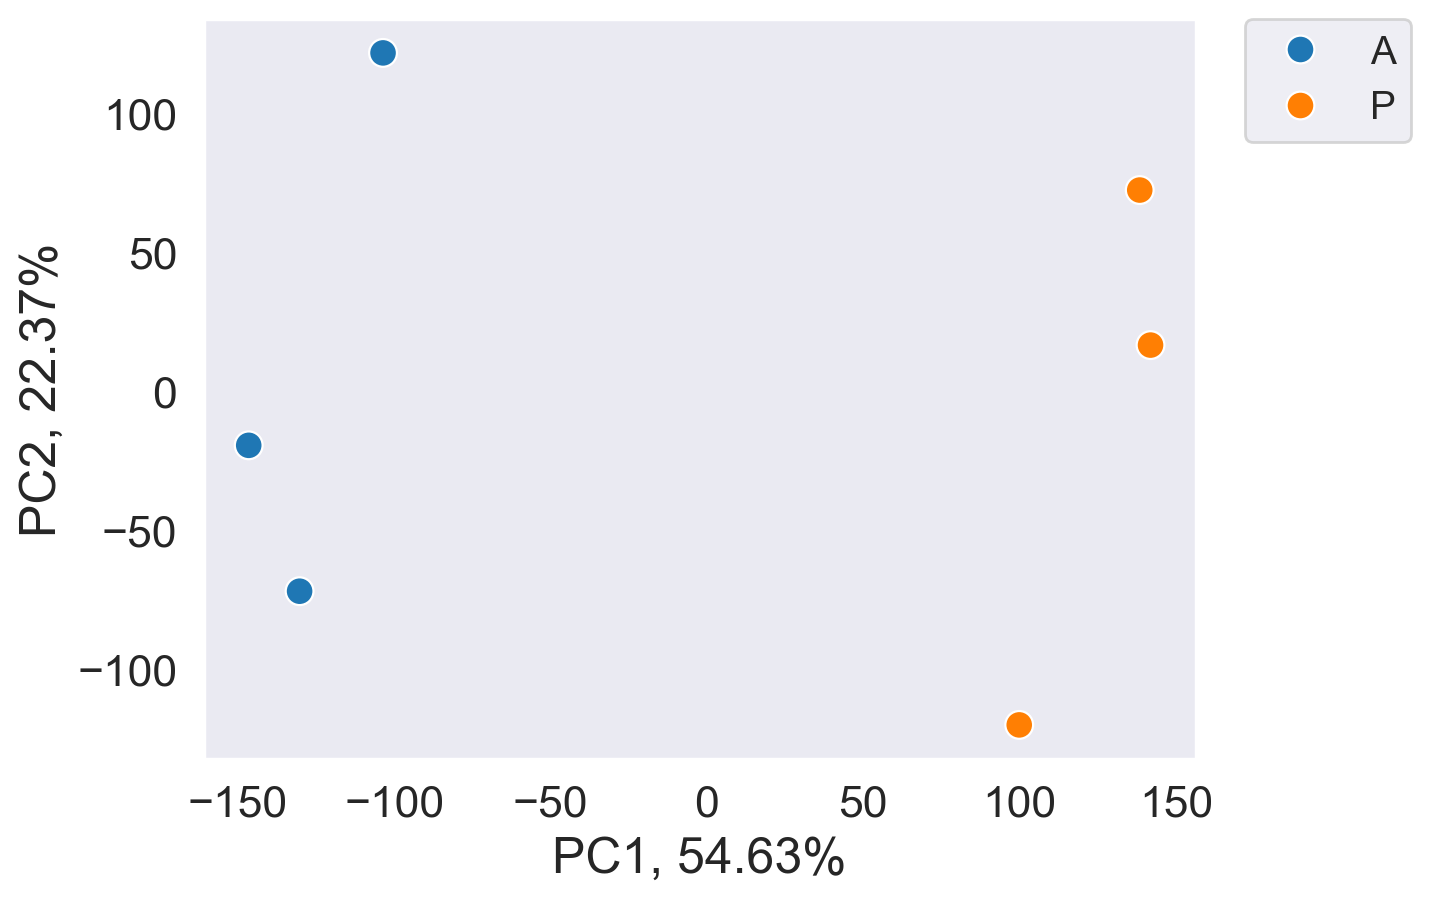

In [4]:
# Standardize the data: mean = 0, std = 1
scaler = SS()
scaled_data = scaler.fit_transform(df.T)

# Perform PCA to reduce to 2 components
pca = PCA(n_components=2)
coords = pca.fit_transform(scaled_data)

# Create DataFrame with PCA results
pc = pd.DataFrame(coords, columns=['PC1', 'PC2'], index=df.T.index)

# Print to check PCA results
print(pc.head())

# Annotate metadata (adjust according to your index format)
pc['treatment'] = pc.index.to_series().str[0]  # Assuming first character for treatment
pc['polarity'] = pc.index.to_series().str[-1]  # Assuming last character for polarity

# Print to check metadata
print(pc[['treatment', 'polarity']].head())

explained_variance = pca.explained_variance_ratio_ * 100  # convert to percentage
# Add variance explained to axis labels
plt.xlabel(f'PC1, {explained_variance[0]:.2f}%')
plt.ylabel(f'PC2, {explained_variance[1]:.2f}%')

# Plot PCA results
sns.scatterplot(x='PC1', y='PC2', hue='treatment', palette=['#1f77b4', '#ff7f03'],
                s=100, data=pc)

# Customize legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# Customize ticks (optional)
# plt.xticks([-50, 0, 50, 100])
# plt.yticks([-50, 0, 50, 100])

# Save the plot
#plt.savefig('PCA_conditions.png', bbox_inches='tight', dpi=300)

plt.show()

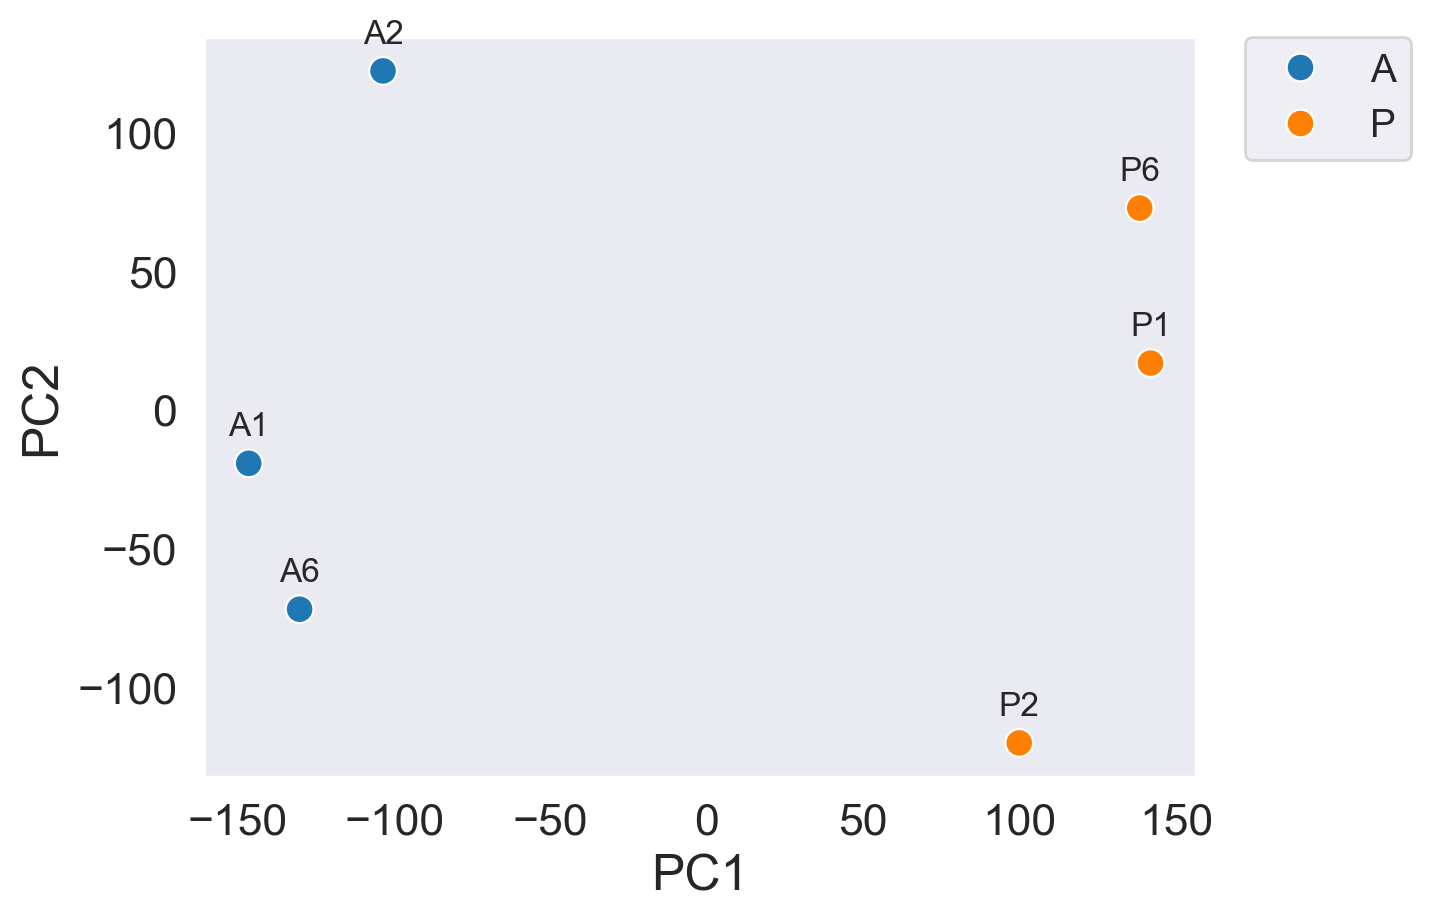

In [5]:
# Scatterplot labeled by sample

sns.scatterplot(x='PC1', y='PC2', hue='treatment', palette=['#1f77b4', '#ff7f03'],
                s=100, data=pc)

# Annotate samples
for sample in pc.index:
    # Get the coordinates for the sample
    x = pc.loc[sample, 'PC1']
    y = pc.loc[sample, 'PC2']
    # Annotate the point
    plt.annotate(sample, (x, y), textcoords="offset points", xytext=(0,10), ha='center')

# Customize legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# Optional: Customize ticks
# plt.xticks([-50, 0, 50, 100])
# plt.yticks([-50, 0, 50, 100])

# Save the plot
#plt.savefig('PCA_bulk_ap.png', bbox_inches='tight', dpi=300)

plt.show()

In [6]:
# pydeseq2 requires integers (no decimals)
# these data were batch corrected in R, hence the decimals 
df = df.clip(lower=0).round().astype(int)

In [7]:
df

,A1,A2,A6,P1,P2,P6
gene,,,,,,
SteCoe_1,3387,3786,3325,3844,3654,3859
SteCoe_10,2606,2710,2363,2851,2661,2978
SteCoe_100,461,519,502,585,566,530
SteCoe_1000,1934,2098,1898,2426,2370,2561
SteCoe_10000,10,10,16,15,17,11
...,...,...,...,...,...,...
SteCoe_9995,1124,1170,1085,1424,1303,1515
SteCoe_9996,203,185,195,256,261,257
SteCoe_9997,1,0,1,2,3,2


## Differential Expression with pydeseq2

In [8]:
inference = DefaultInference(n_cpus=8)

In [9]:
dds = DeseqDataSet(
    counts=df.T,
    metadata=s2c,
    design_factors="condition",
    refit_cooks=True,
    inference=inference,
)

In [10]:
dds

AnnData object with n_obs × n_vars = 6 × 34494
    obs: 'condition', 'batch'
    obsm: 'design_matrix'

In [11]:
dds.deseq2()

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 5.46 seconds.

Fitting dispersion trend curve...
... done in 0.54 seconds.

Fitting MAP dispersions...
... done in 7.00 seconds.

Fitting LFCs...
... done in 3.02 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.



In [12]:
dds

AnnData object with n_obs × n_vars = 6 × 34494
    obs: 'condition', 'batch'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', '_mu_LFC', '_hat_diagonals', 'replaceable'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted'
    layers: 'normed_counts', '_mu_hat', 'cooks'

In [13]:
stat_res = DeseqStats(dds, inference=inference, alpha = 0.2, contrast = ["condition", "anterior", "posterior"])

In [14]:
SAVE = False  # whether to save the outputs of this notebook

if SAVE:
    # Replace this with the path to directory where you would like results to be saved
    OUTPUT_PATH = "../output_files/synthetic_example"
    os.makedirs(OUTPUT_PATH, exist_ok=True)  # Create path if it doesn't exist

In [15]:
stat_res.summary()

if SAVE:
    with open(os.path.join(OUTPUT_PATH, "stat_results.pkl"), "wb") as f:
        pkl.dump(stat_res, f)

Running Wald tests...


Log2 fold change & Wald test p-value: condition anterior vs posterior
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene                                                                      
SteCoe_1      3628.717071        0.150560  0.058070  2.592724  0.009522   
SteCoe_10     2682.190354        0.120079  0.066991  1.792464  0.073059   
SteCoe_100     524.208955        0.081943  0.103414  0.792383  0.428137   
SteCoe_1000   2192.620079       -0.046737  0.062227 -0.751067  0.452612   
SteCoe_10000    13.085419        0.007010  0.592042  0.011840  0.990553   
...                   ...             ...       ...       ...       ...   
SteCoe_9995   1256.799670       -0.062867  0.076557 -0.821171  0.411549   
SteCoe_9996    223.439078       -0.143709  0.146802 -0.978932  0.327614   
SteCoe_9997      1.431868       -1.538231  1.822478 -0.844033  0.398651   
SteCoe_9998   1589.375789        0.029758  0.066631  0.446607  0.655159   
SteCoe_9999    437.640265     

... done in 1.61 seconds.



In [16]:
res = stat_res.results_df

## Volcano Plots 

In [17]:
# Define significance threshold, using a very permissive value here for candidate generation purposes 
significance_threshold = 0.2

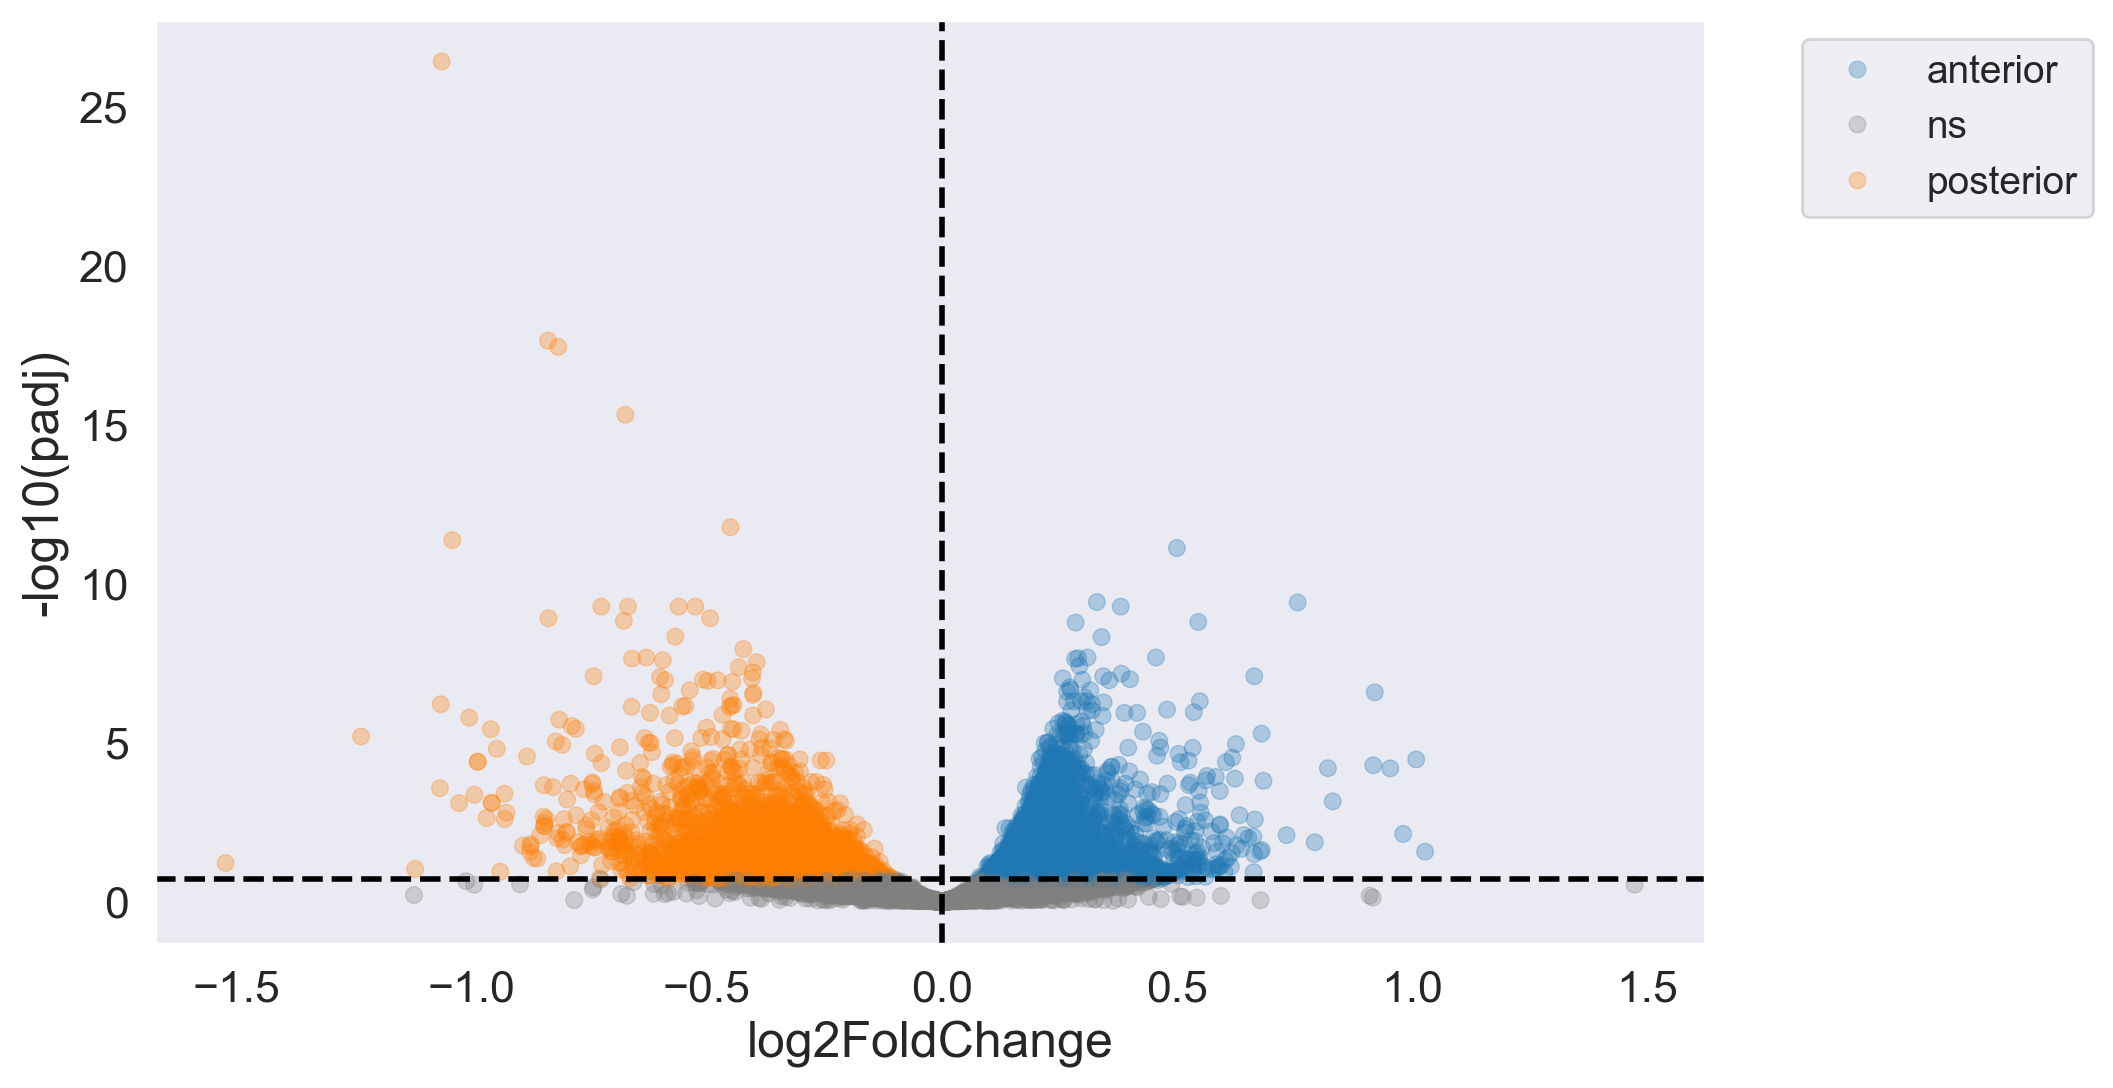

In [18]:
# Create a new column to color points based on significance and log2FoldChange
res['color'] = np.where((res['padj'] < significance_threshold) & (res['log2FoldChange'] > 0), 'anterior',
                        np.where((res['padj'] < significance_threshold) & (res['log2FoldChange'] < 0), 'posterior', 'ns'))

# Calculate -log10(padj) for the y-axis
res['-log10(padj)'] = -np.log10(res['padj'])

# Plotting
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=res, 
    x='log2FoldChange', 
    y='-log10(padj)', 
    hue='color', 
    palette={'posterior': '#ff7f03', 'anterior': '#1f77b4', 'ns': 'gray'}, 
    alpha=0.3, 
    edgecolor=None
)

# Add vertical and horizontal lines for thresholds
plt.axhline(y=-np.log10(significance_threshold), color='black', linestyle='--')
plt.axvline(x=0, color='black', linestyle='--')
plt.xlabel('log2FoldChange')
plt.ylabel('-log10(padj)')
plt.title('')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

#plt.savefig('volcano_ap.png', bbox_inches='tight', dpi=300)

#plt.tight_layout()
plt.show()



In [21]:
sig_df = res[res.padj < significance_threshold]

In [22]:
sig_df.sort_values('log2FoldChange') 

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,color,-log10(padj)
gene,,,,,,,,
SteCoe_33495,176.946038,-1.523203,0.592743,-2.569751,1.017718e-02,6.180512e-02,posterior,1.208976
SteCoe_38454,151.726358,-1.235249,0.224555,-5.500868,3.779270e-08,6.456203e-06,posterior,5.190023
SteCoe_31006,219.197910,-1.120230,0.477626,-2.345412,1.900608e-02,9.464923e-02,posterior,1.023883
SteCoe_27200,203.941606,-1.067578,0.235659,-4.530186,5.893173e-06,2.717987e-04,posterior,3.565753
SteCoe_35404,288.082958,-1.065830,0.177583,-6.001851,1.950811e-09,6.217554e-07,posterior,6.206380
...,...,...,...,...,...,...,...,...
SteCoe_33998,876.310380,0.920196,0.149038,6.174216,6.649265e-10,2.629415e-07,anterior,6.580141
SteCoe_12520,169.096611,0.953022,0.193267,4.931122,8.175864e-07,6.490238e-05,anterior,4.187739
SteCoe_15684,87.529280,0.980530,0.283286,3.461267,5.376395e-04,7.459879e-03,anterior,2.127268


In [23]:
sig_df['color'].value_counts()

color
anterior     3456
posterior    2836
Name: count, dtype: int64

## Heatmap

In [24]:
dds

AnnData object with n_obs × n_vars = 6 × 34494
    obs: 'condition', 'batch'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', '_mu_LFC', '_hat_diagonals', 'replaceable'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted'
    layers: 'normed_counts', '_mu_hat', 'cooks'

In [25]:
dds.layers['log1p'] = np.log1p(dds.layers['normed_counts'])

In [26]:
# grab top pos and neg genes 
top_pos_genes = sig_df.nlargest(10, 'log2FoldChange').index  # Top 10 positive genes
top_neg_genes = sig_df.nsmallest(10, 'log2FoldChange').index  # Top 10 negative genes

# combine top pos and neg genes 
top_genes = top_pos_genes.union(top_neg_genes)

In [27]:
dds_top = dds[:, dds.var_names.isin(top_genes)]

In [28]:
sig_heat_df = pd.DataFrame(dds_top.layers['log1p'].T, index = dds_top.var_names, columns=dds_top.obs_names)

In [29]:
sig_heat_df

sample,A1,A2,A6,P1,P2,P6
gene,,,,,,
SteCoe_12520,5.357004,5.229505,5.610315,4.739334,4.817120,4.705863
SteCoe_1382,4.647485,4.408066,5.076216,5.416176,5.524901,5.352826
SteCoe_14521,7.122671,6.998441,7.244635,7.809293,7.842301,7.935174
SteCoe_15684,4.719385,4.947404,4.592040,4.085612,3.712124,4.371382
SteCoe_16564,4.729247,4.679576,4.569544,4.144356,3.934920,4.250918
SteCoe_17788,5.665551,5.471969,5.410903,4.807743,4.778824,5.058192
SteCoe_20838,5.555864,5.387782,5.851841,5.000890,5.178870,4.936914
SteCoe_2716,5.498427,5.444686,5.401047,4.878639,4.786601,4.974866
SteCoe_27200,5.101791,4.954955,4.522976,5.428099,5.479452,5.896926


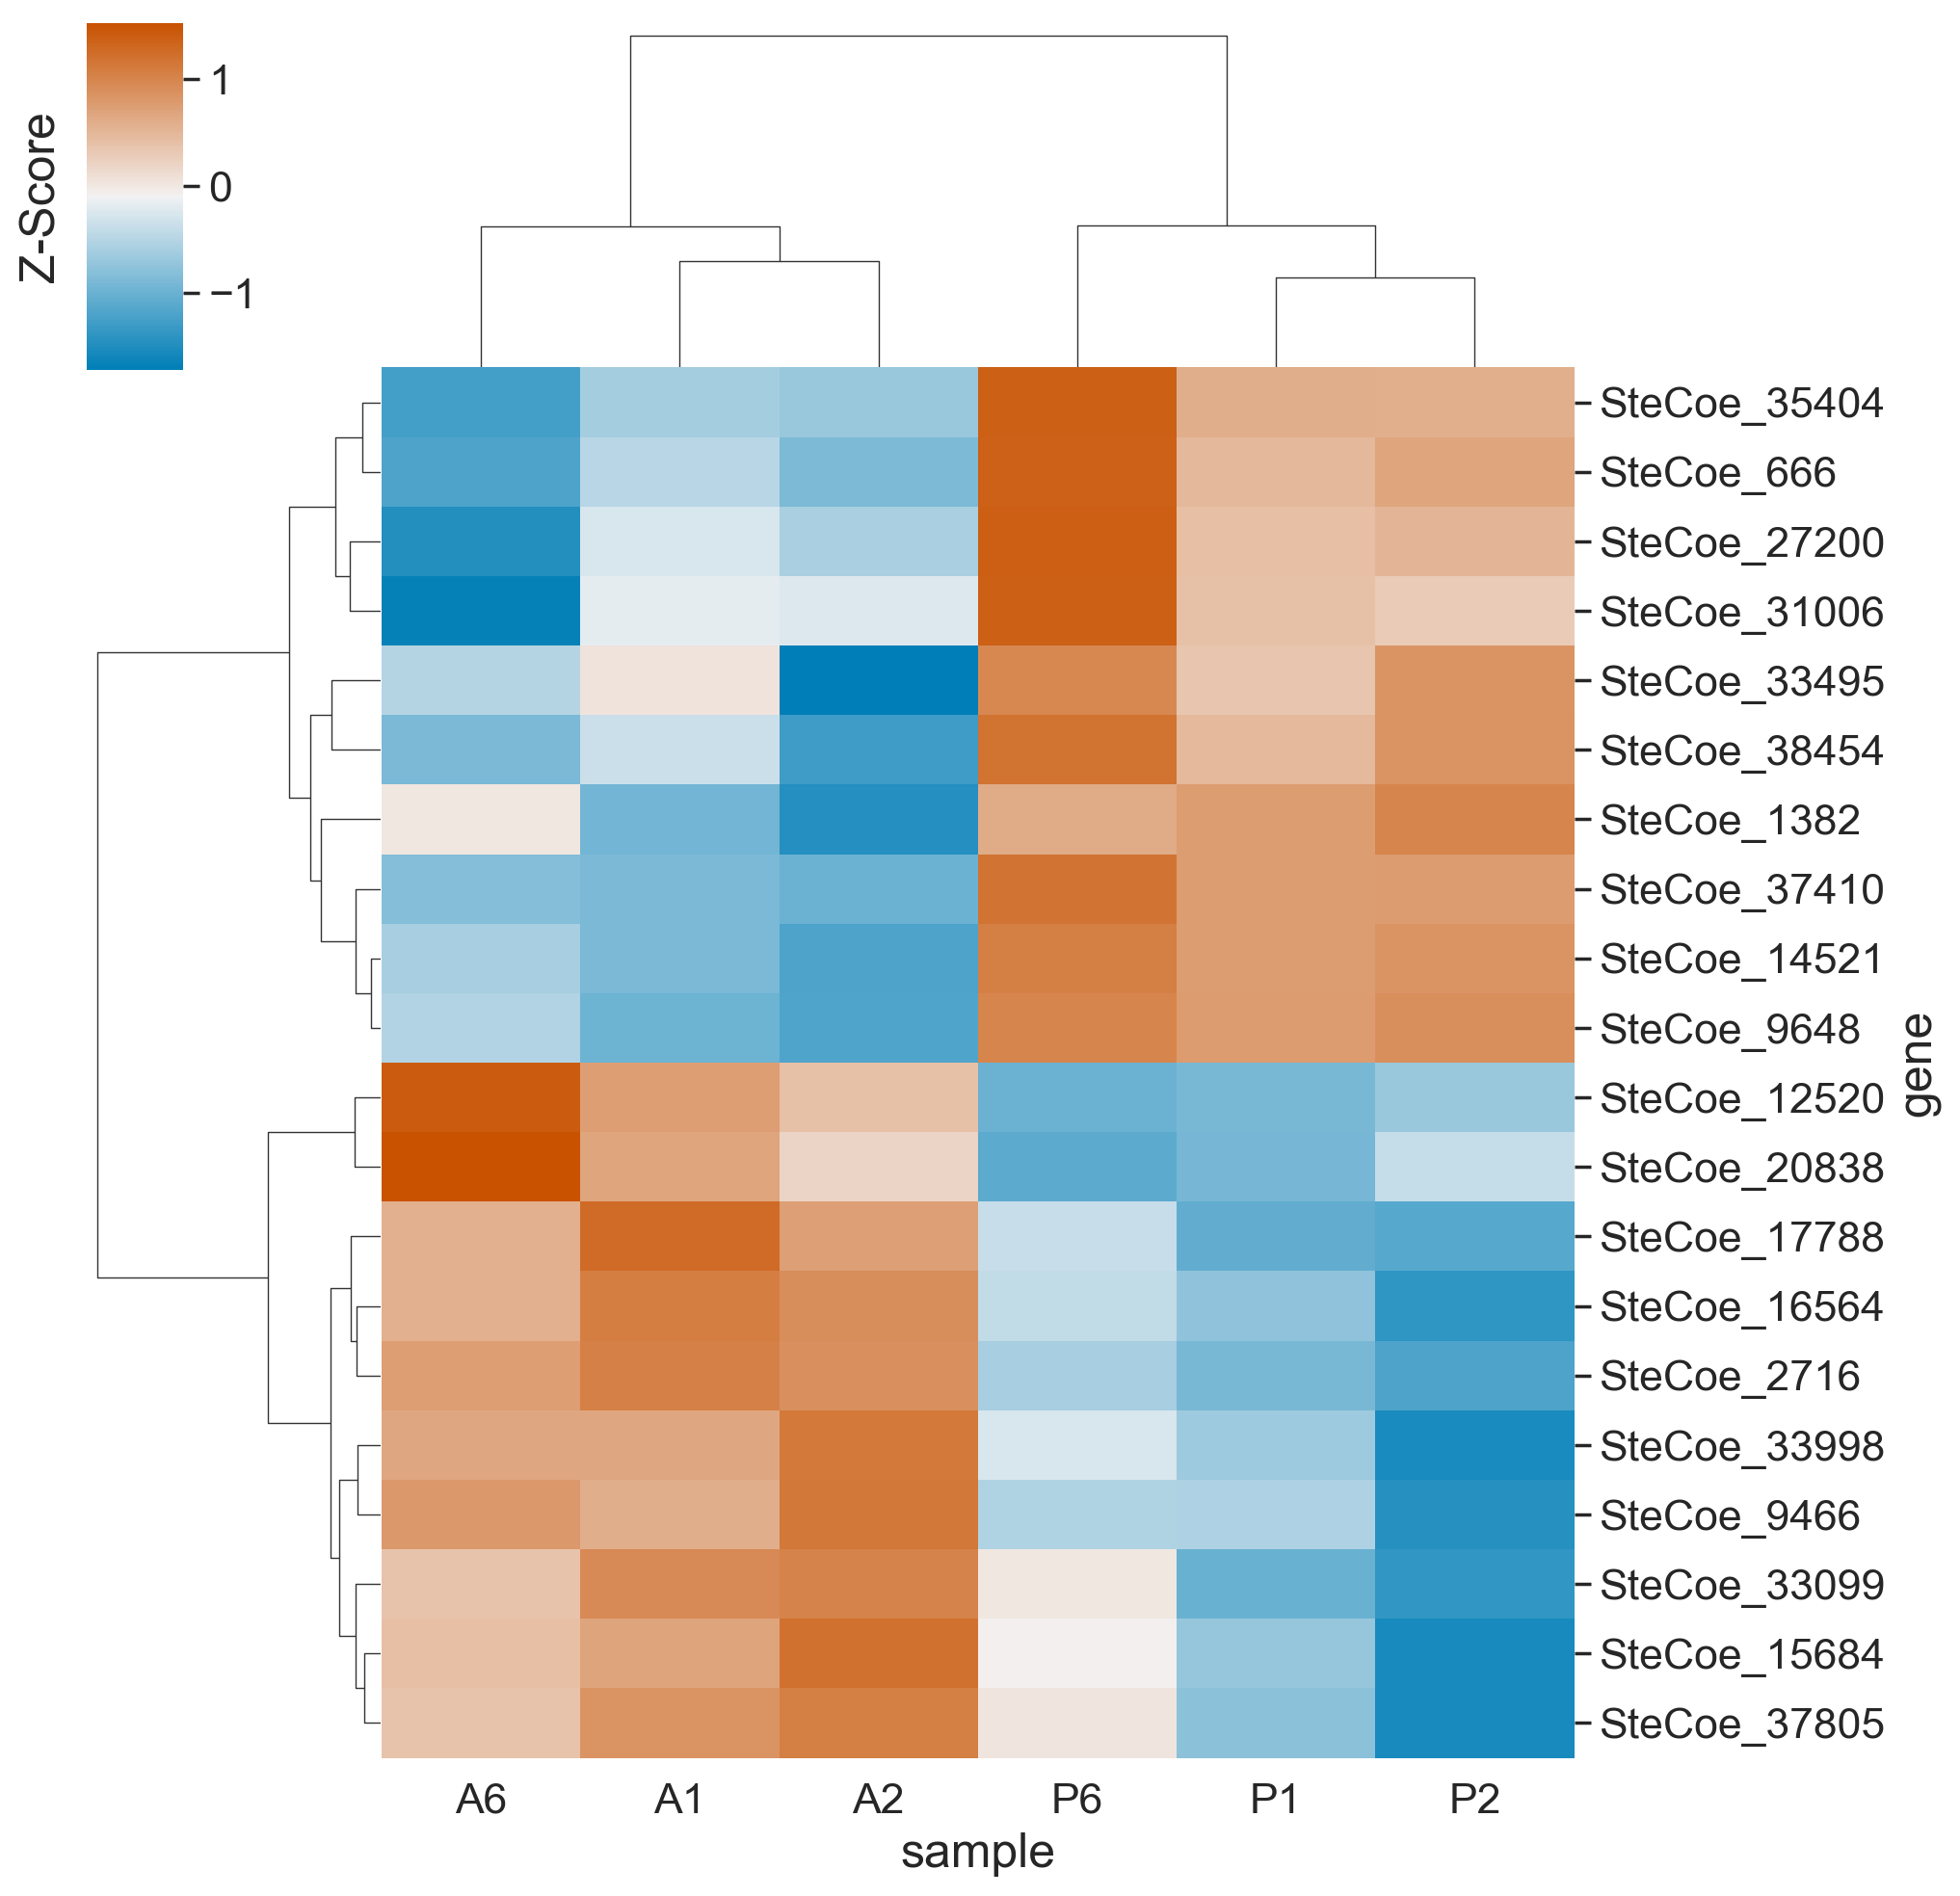

In [30]:
palette = sns.diverging_palette(240, 24, s = 100, l = 50, as_cmap=True)

p = sns.clustermap(sig_heat_df, z_score=0, cmap = palette)
cbar = p.ax_cbar
cbar.set_ylabel('Z-Score') # Set the label for the colorbar
cbar.yaxis.set_label_coords(-0.7, 0.5) 


#plt.savefig('sig_heatmap.png', bbox_inches='tight', dpi=300)

## Overlap with tubulin and dynein data 

In [34]:
# read in significant skews from tubulin and dynein analysis 
ap_tub = pd.read_csv('/Volumes/albright_postdoc/2022_AADAWM_v3/4_overlap/ap_tub_overlap.csv')
ap_dyn = pd.read_csv('/Volumes/albright_postdoc/2022_AADAWM_v3/4_overlap/ap_G04_overlap.csv')

In [35]:
# filter dds results for overlapping genes
dds_ap_tub = dds[:,dds.var_names.isin(ap_tub['gene'])]
dds_ap_dyn = dds[:,dds.var_names.isin(ap_dyn['gene'])]

In [36]:
# grab the log1p layer into a df 
ap_tub_df = pd.DataFrame(dds_ap_tub.layers['log1p'].T, index = dds_ap_tub.var_names, columns=dds_ap_tub.obs_names)
ap_dyn_df = pd.DataFrame(dds_ap_dyn.layers['log1p'].T, index = dds_ap_dyn.var_names, columns=dds_ap_dyn.obs_names)

In [1]:
ap_tub_df

NameError: name 'ap_tub_df' is not defined

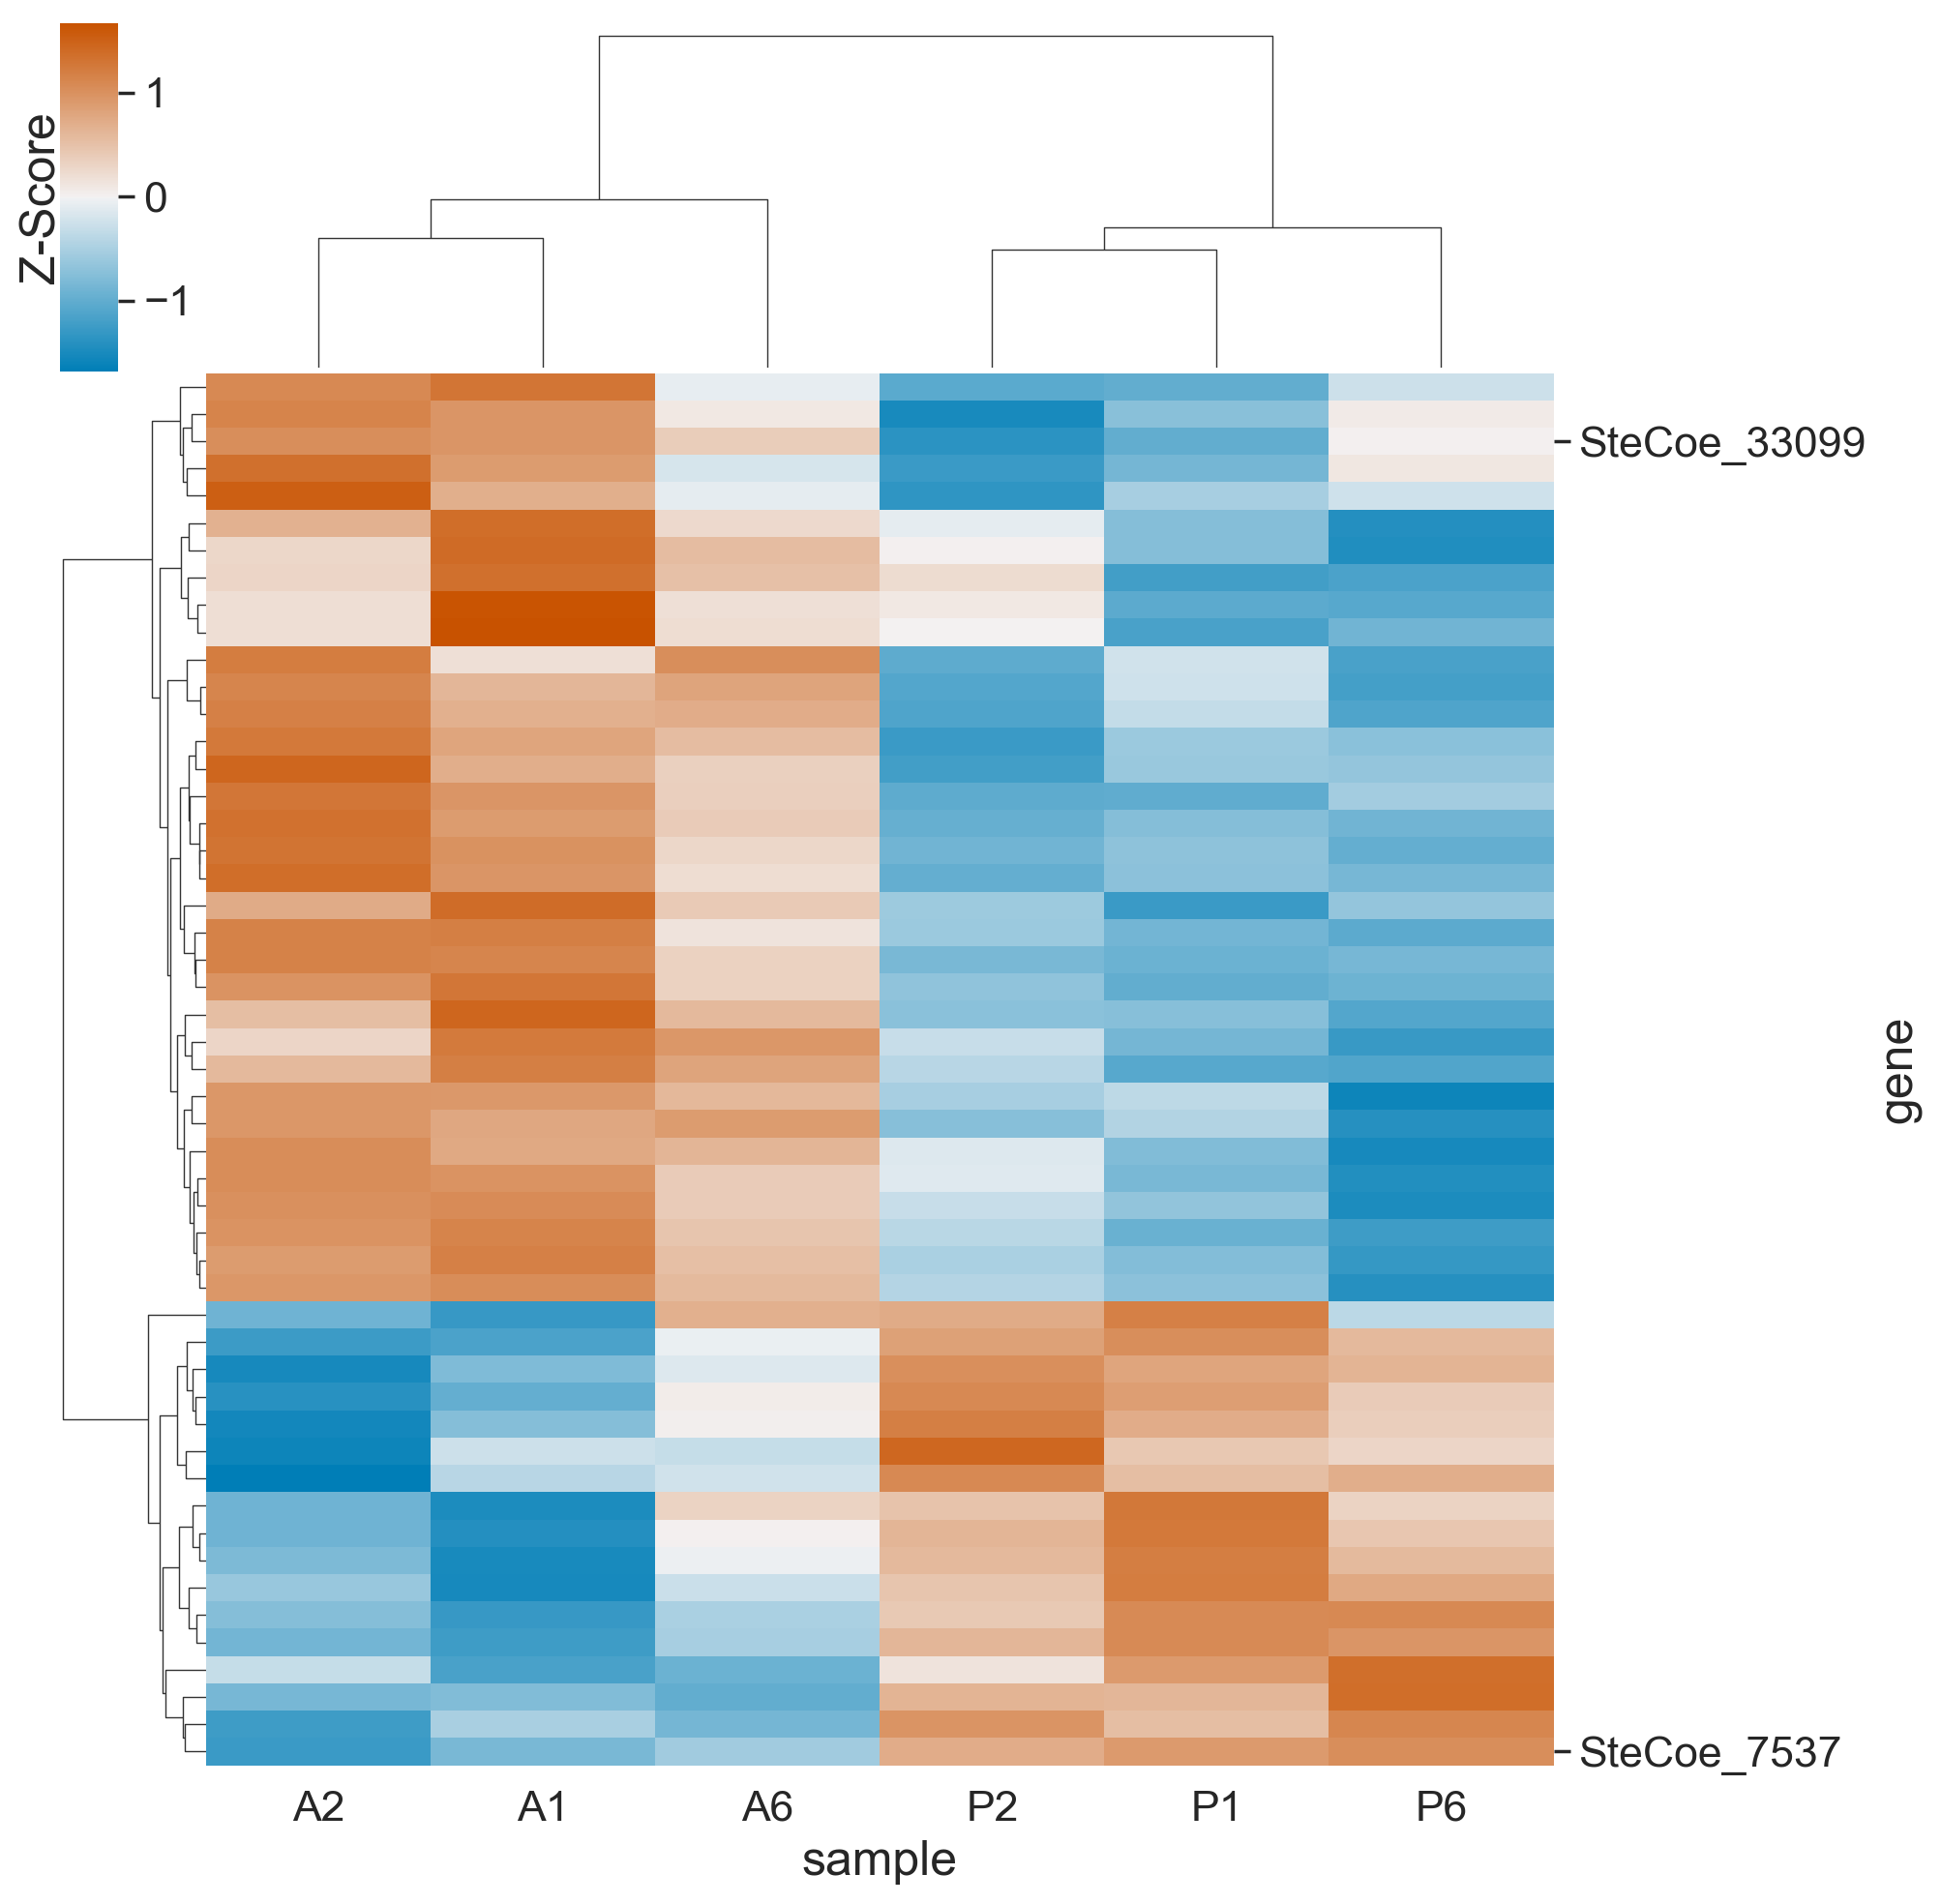

In [37]:
palette = sns.diverging_palette(240, 24, s = 100, l = 50, as_cmap=True)

p = sns.clustermap(ap_tub_df, 
                   z_score=0, 
                   cmap = palette, 
                   dendrogram_ratio=(0.1,0.2),
                   )

# just to make the direction nice and matchy
p.ax_heatmap.invert_xaxis()
p.ax_col_dendrogram.invert_xaxis()

# grab dendrogram labels 
reordered_labels = ap_tub_df.index[p.dendrogram_row.reordered_ind].tolist()

# genes to label 
use_labels = ["SteCoe_33099", 'SteCoe_7537']
use_ticks = [reordered_labels.index(label) + 0.5 for label in use_labels]

# specific labels 
p.ax_heatmap.set(yticks=use_ticks, yticklabels=use_labels)

# color bar position and such 
cbar_pos = cbar.get_position()
cbar = p.ax_cbar
cbar.set_ylabel('Z-Score') # Set the label for the colorbar
cbar.yaxis.set_label_coords(-0.7, 0.5) 
cbar.set_position([cbar_pos.x0, cbar_pos.y0, 0.03, cbar_pos.height])


#plt.savefig('ap_tub_heatmap.png', bbox_inches='tight', dpi=300)

In [38]:
# grab dendrogram cluster order for use with tubulin data 
tub_cm_order = pd.Series(ap_tub_df.index[p.dendrogram_row.reordered_ind])

In [39]:
#tub_cm_order.to_csv('tub_cm_order.csv', index = False)

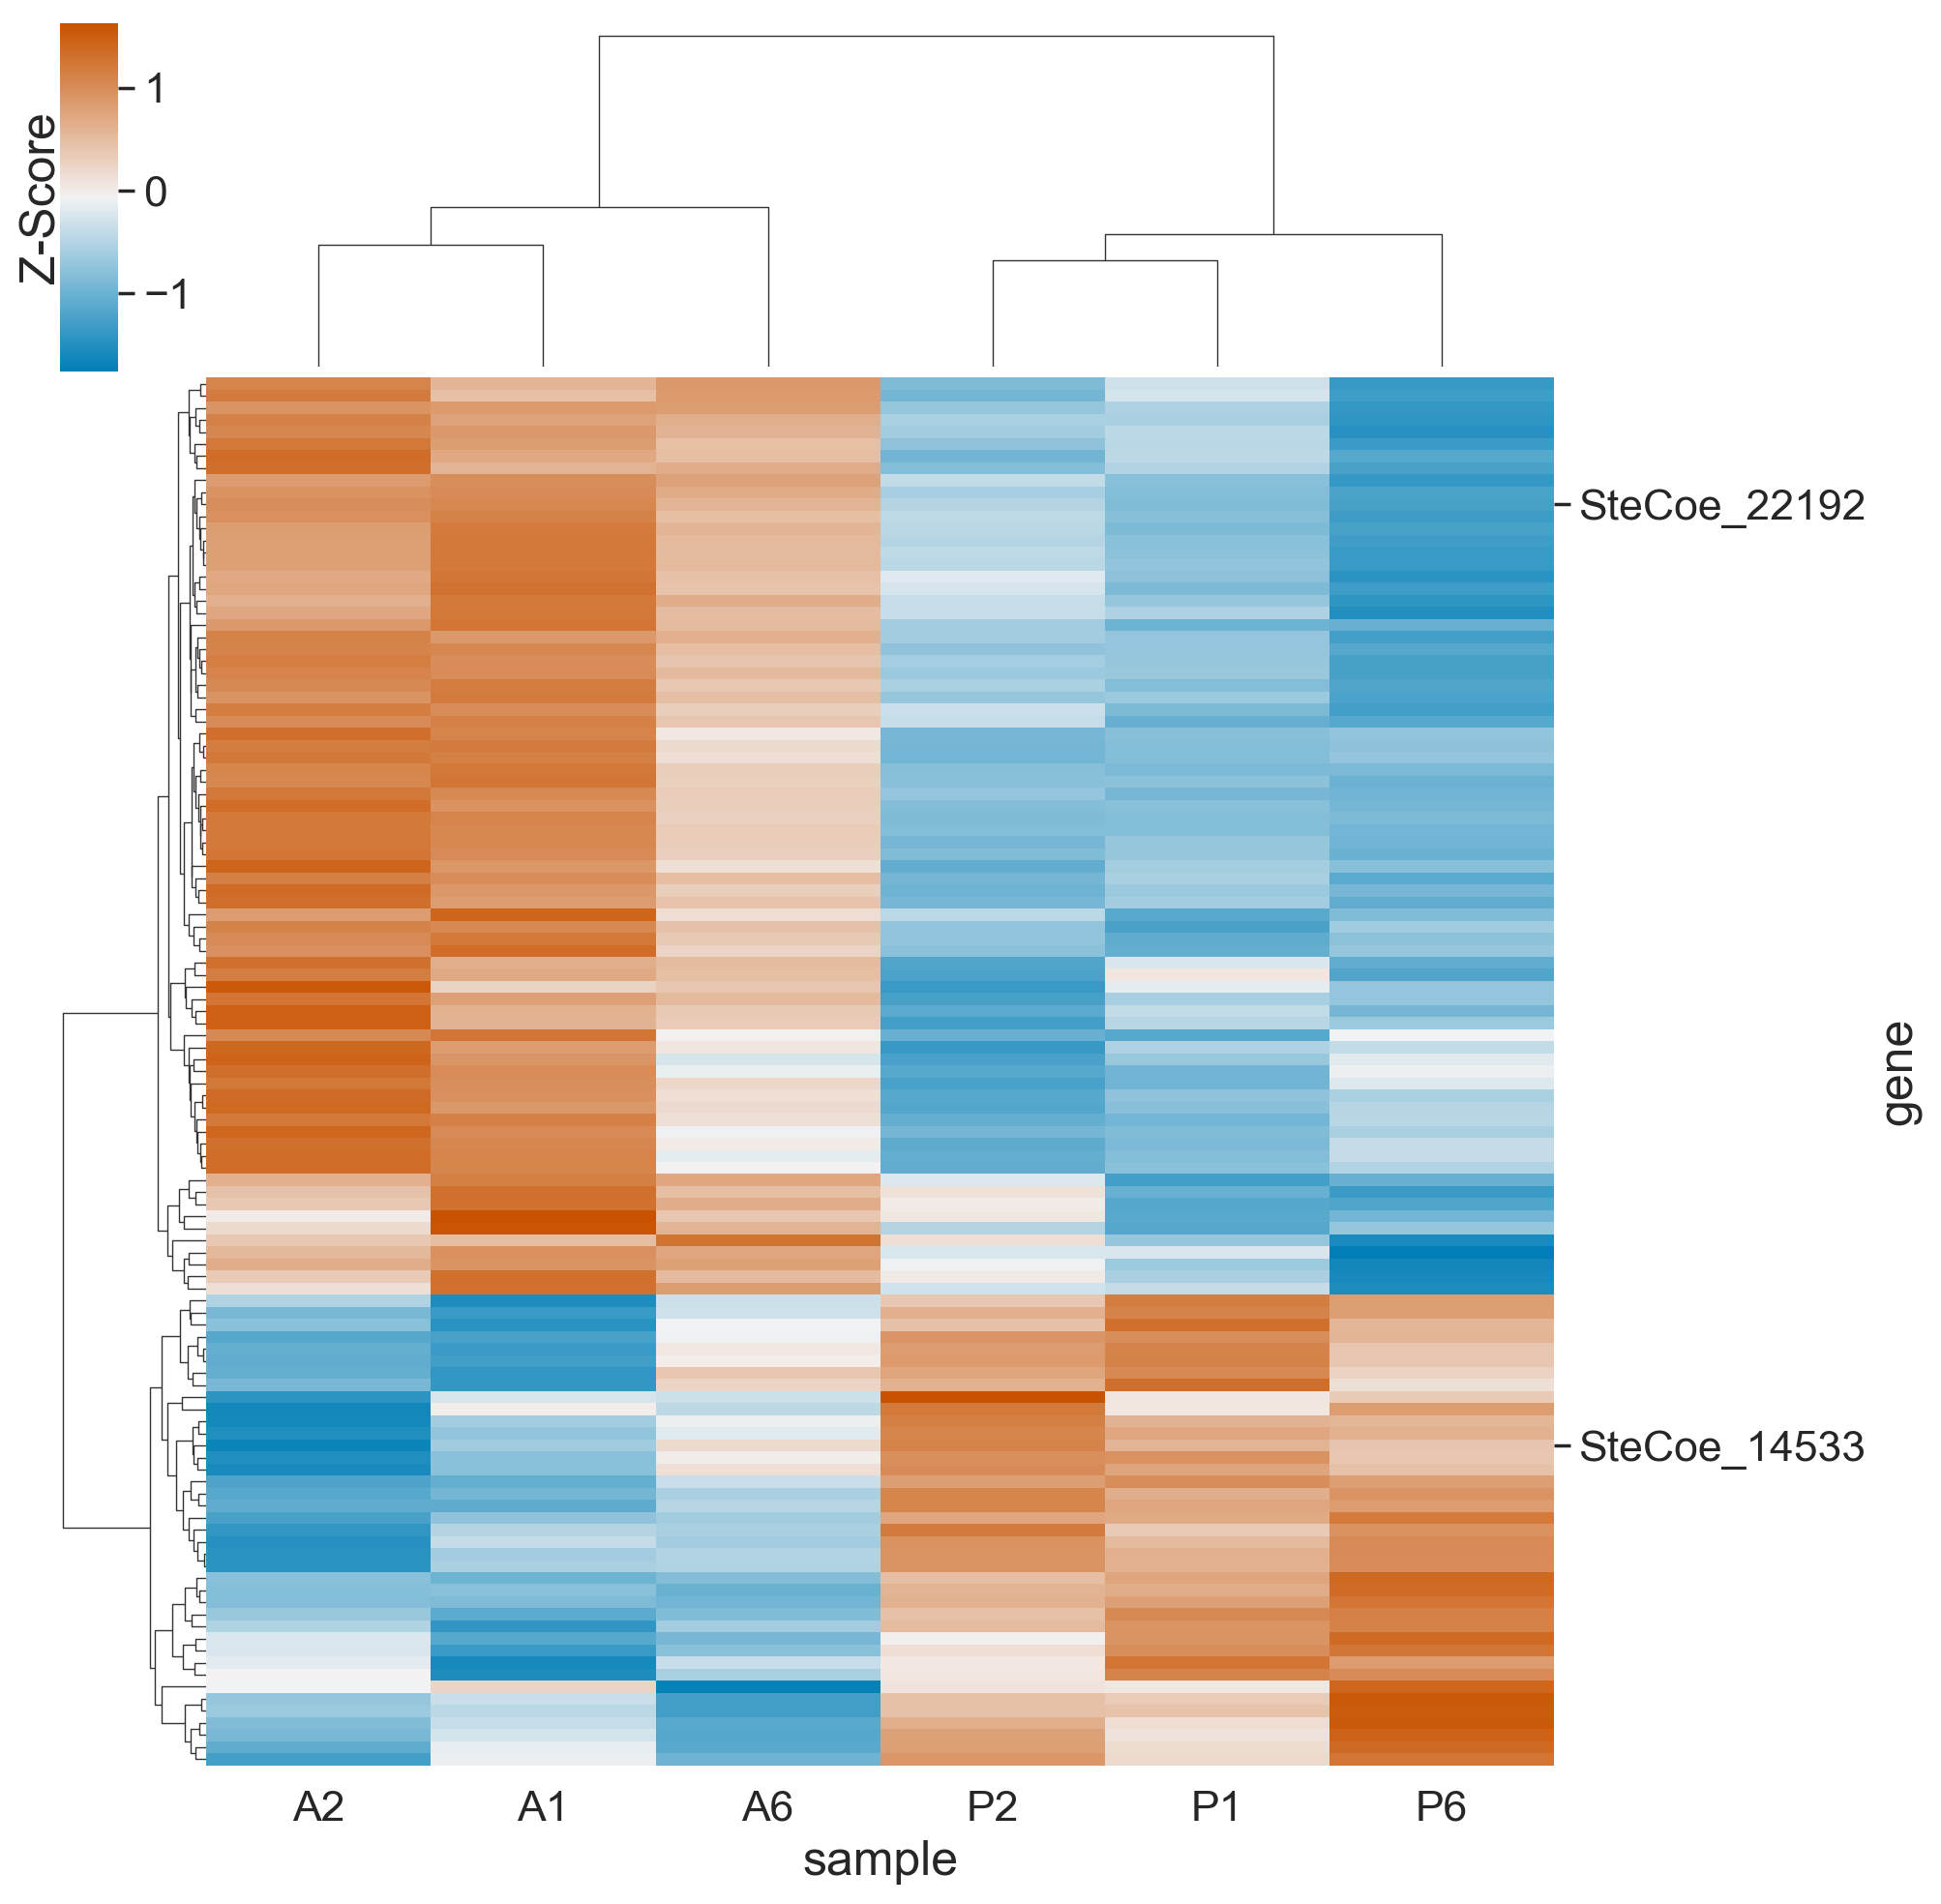

In [40]:
palette = sns.diverging_palette(240, 24, s = 100, l = 50, as_cmap=True)

p = sns.clustermap(ap_dyn_df, 
                   z_score=0, 
                   cmap = palette, 
                   dendrogram_ratio=(0.1,0.2),
                   )

# just to make the direction nice and matchy
p.ax_heatmap.invert_xaxis()
p.ax_col_dendrogram.invert_xaxis()

# grab dendrogram labels
reordered_labels = ap_dyn_df.index[p.dendrogram_row.reordered_ind].tolist()

# genes to label 
use_labels = ["SteCoe_22192", 'SteCoe_14533']
use_ticks = [reordered_labels.index(label) + 0.5 for label in use_labels]

# specific labels 
p.ax_heatmap.set(yticks=use_ticks, yticklabels=use_labels)

# color bar position and such 
cbar_pos = cbar.get_position()
cbar = p.ax_cbar
cbar.set_ylabel('Z-Score') # Set the label for the colorbar
cbar.yaxis.set_label_coords(-0.7, 0.5) 
cbar.set_position([cbar_pos.x0, cbar_pos.y0, 0.03, cbar_pos.height])


#plt.savefig('ap_dyn_heatmap.png', bbox_inches='tight', dpi=300)

In [41]:
# save dynein order 
dyn_cm_order = pd.Series(ap_dyn_df.index[p.dendrogram_row.reordered_ind])
#dyn_cm_order.to_csv('dyn_cm_order.csv', index = False)

## Overlap AP counts with proteome tandem tagging data

Paper: Determining protein polarization proteome-wide using physical dissection of individual Stentor coeruleus cells (Lin et al 2022)

https://www.cell.com/current-biology/fulltext/S0960-9822(22)00565-6?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0960982222005656%3Fshowall%3Dtrue

In [42]:
A_athena = pd.read_csv('/Volumes/albright_postdoc/2022_AADAWM_v3/bin/A_athena.csv')
P_athena = pd.read_csv('/Volumes/albright_postdoc/2022_AADAWM_v3/bin/P_athena.csv')
MB_athena = pd.read_csv('/Volumes/albright_postdoc/2022_AADAWM_v3/bin/MB_athena.csv')

In [43]:
len(A_athena)

31

In [50]:
sig_df['color'][sig_df.index.isin(A_athena['Protein'])].value_counts()

color
anterior     23
posterior     1
Name: count, dtype: int64

In [45]:
len(P_athena)

10

In [49]:
sig_df['color'][sig_df.index.isin(P_athena['Protein'])].value_counts()

color
anterior    5
Name: count, dtype: int64

In [47]:
len(MB_athena)

129

In [48]:
sig_df['color'][sig_df.index.isin(MB_athena['Protein'])].value_counts()

color
anterior     24
posterior     7
Name: count, dtype: int64

In [52]:
from scipy.stats import fisher_exact

# data
data = {
    'Anterior Protein': [23, 1],  
    'Posterior Protein': [5, 0],  
    'Membranellar Protein': [24, 7]  
}

# contingency table (not testing MB) 
contingency_table = pd.DataFrame(data, index=['Anterior RNA', 'Posterior RNA'])

# Extract the 2x2 contingency table for Fisher's test
# Let's take Anterior and Posterior Protein as an example (2x2 table)
test_table = contingency_table[['Anterior Protein', 'Posterior Protein']].values

# Perform Fisher's Exact Test
odds_ratio, p_value = fisher_exact(test_table)

# Output the results
print(f"Odds Ratio: {odds_ratio}")
print(f"P-value: {p_value}")


Odds Ratio: 0.0
P-value: 1.0


## Single Gene Plots

In [72]:
# make gene names a column
sig_heat_df_reset = sig_heat_df.reset_index()

# check structure 
print(sig_heat_df_reset.head())  

# melt to long format
sig_heat_df_long = sig_heat_df_reset.melt(id_vars=sig_heat_df_reset.columns[0], 
                                           var_name='Sample', 
                                           value_name='Expression')

# rename 'Gene' 
sig_heat_df_long.rename(columns={sig_heat_df_reset.columns[0]: 'Gene'}, inplace=True)

# new column (Anterior or Posterior)
sig_heat_df_long['Condition'] = sig_heat_df_long['Sample'].str[0].map({'A': 'Anterior', 'P': 'Posterior'})


sample          gene        A1        A2        A6        P1        P2  \
0       SteCoe_12520  5.357004  5.229505  5.610315  4.739334  4.817120   
1        SteCoe_1382  4.647485  4.408066  5.076216  5.416176  5.524901   
2       SteCoe_14521  7.122671  6.998441  7.244635  7.809293  7.842301   
3       SteCoe_15684  4.719385  4.947404  4.592040  4.085612  3.712124   
4       SteCoe_16564  4.729247  4.679576  4.569544  4.144356  3.934920   

sample        P6  
0       4.705863  
1       5.352826  
2       7.935174  
3       4.371382  
4       4.250918  


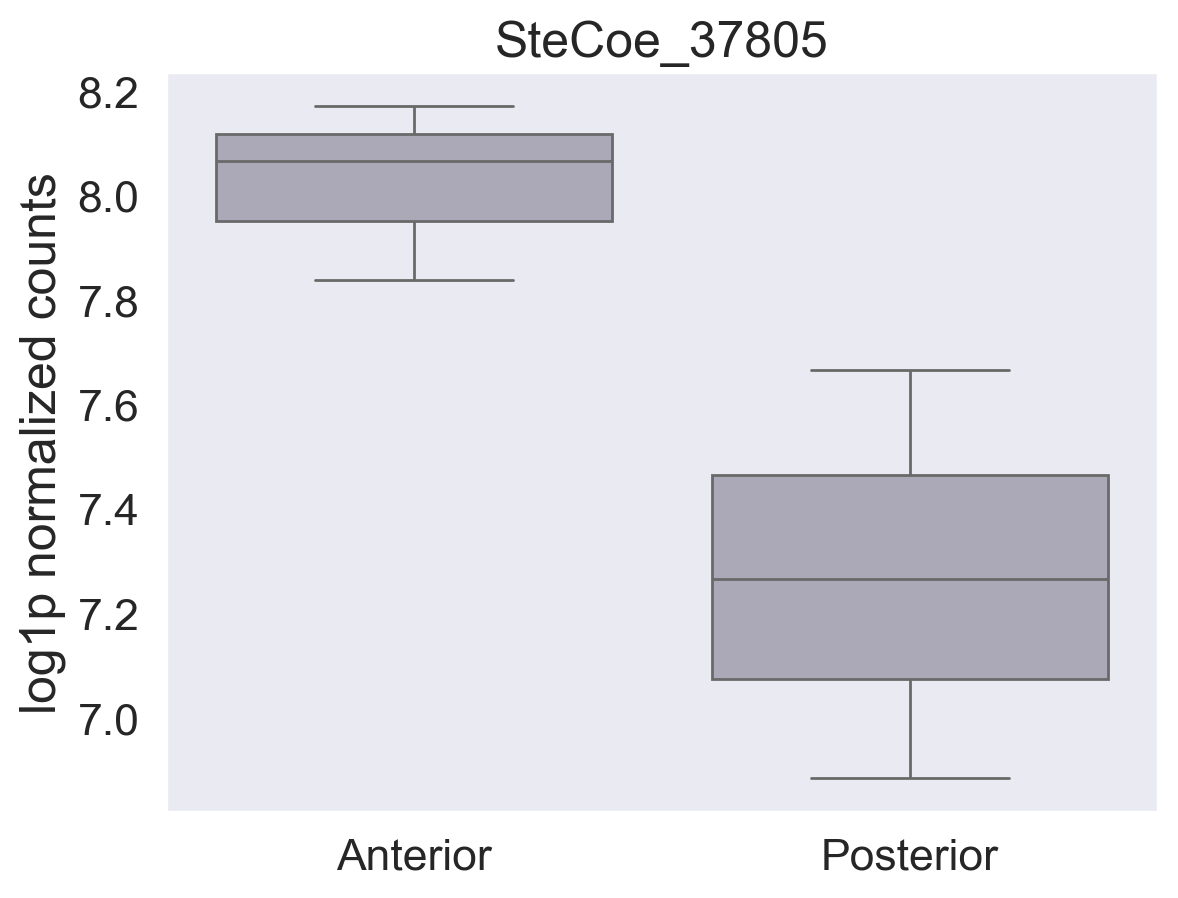

In [75]:
goi = 'SteCoe_37805' # gene of interest 

# boxplot
sns.boxplot(x='Condition', y='Expression', 
            data=sig_heat_df_long[sig_heat_df_long['Gene'] == goi],
            color='#A9A5BA')
plt.title(f'{goi}')
plt.ylabel('log1p normalized counts')
plt.xlabel('')

plt.savefig('SteCoe_37805.png', bbox_inches='tight', dpi = 300)

plt.show()

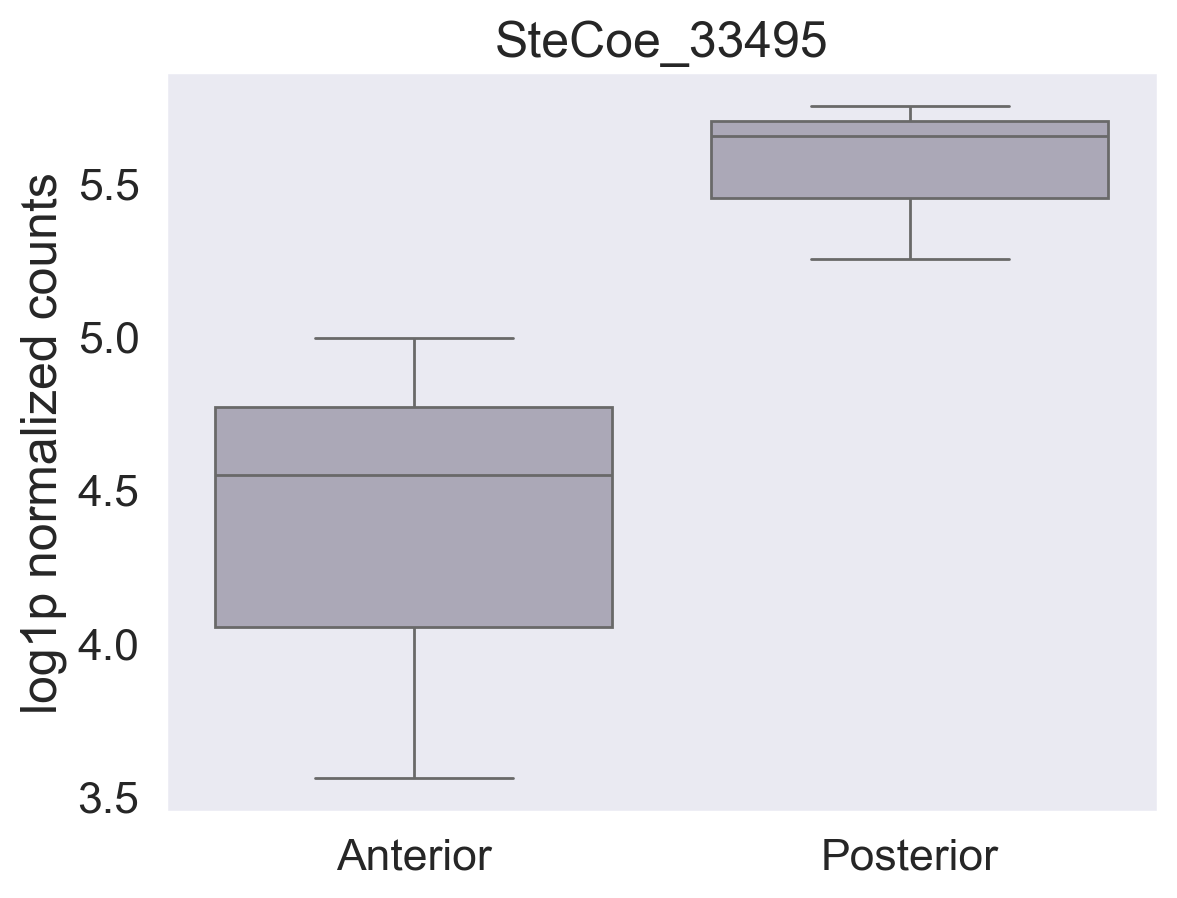

In [77]:
goi = 'SteCoe_33495' # gene of interest 

# boxplot
sns.boxplot(x='Condition', y='Expression', 
            data=sig_heat_df_long[sig_heat_df_long['Gene'] == goi],
            color='#A9A5BA')
plt.title(f'{goi}')
plt.ylabel('log1p normalized counts')
plt.xlabel('')


plt.savefig('SteCoe_33495.png', bbox_inches='tight', dpi = 300)

plt.show()

## Add protein domain to final table
Note: these are the older annotations from when the genome was published, Uniprot may have new annotations 

In [36]:
# load protein domain information 

x = []
y = []
with open('/Users/aralbright/Documents/GitHub/2022_skew_analysis/S_coeruleus_Nov2017_proteins.fasta') as f:
    lines = f.readlines()
    for l in lines:
        if '>' in l:
            line = l.split('\t')
            gene = line[0][1:]
            domain = line[1].strip()
            x += [gene]
            y += [domain]

prot_data = pd.DataFrame([x, y], index=['gene', 'domain']).T.set_index('gene')

In [37]:
prot_data

,domain
gene,
SteCoe_1,Gp_dh_N domain protein
SteCoe_2,hypothetical protein
SteCoe_3,hypothetical protein
SteCoe_4,hypothetical protein
SteCoe_5,hypothetical protein
...,...
SteCoe_40812,hypothetical protein
SteCoe_40902,hypothetical protein
SteCoe_40903,GSHPx domain protein


In [38]:
 # append domain information to mean_skews dataframe
sig_df = sig_df.join(prot_data, on='gene')

In [39]:
sig_df.sort_values('log2FoldChange')

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,color,-log10(padj),domain
gene,,,,,,,,,
SteCoe_33495,176.946038,-1.523203,0.592743,-2.569751,1.017718e-02,6.180513e-02,posterior,1.208976,hypothetical protein
SteCoe_38454,151.726358,-1.235249,0.224555,-5.500868,3.779270e-08,6.456202e-06,posterior,5.190023,NIF domain protein
SteCoe_31006,219.197910,-1.120230,0.477626,-2.345412,1.900608e-02,9.467130e-02,posterior,1.023782,hypothetical protein
SteCoe_27200,203.941606,-1.067578,0.235659,-4.530186,5.893172e-06,2.717987e-04,posterior,3.565753,zf-LITAF-like domain protein
SteCoe_35404,288.082958,-1.065830,0.177583,-6.001851,1.950810e-09,6.217553e-07,posterior,6.206380,hypothetical protein
...,...,...,...,...,...,...,...,...,...
SteCoe_33998,876.310380,0.920196,0.149038,6.174216,6.649262e-10,2.629414e-07,anterior,6.580141,hypothetical protein
SteCoe_12520,169.096611,0.953022,0.193267,4.931122,8.175864e-07,6.490238e-05,anterior,4.187739,Ribosomal_L38e domain protein
SteCoe_15684,87.529280,0.980530,0.283286,3.461267,5.376395e-04,7.455035e-03,anterior,2.127550,hypothetical protein


In [40]:
# save to csv 
#sig_df.to_csv('ap_sig_df_qval0pt2.csv')

### Extras: 

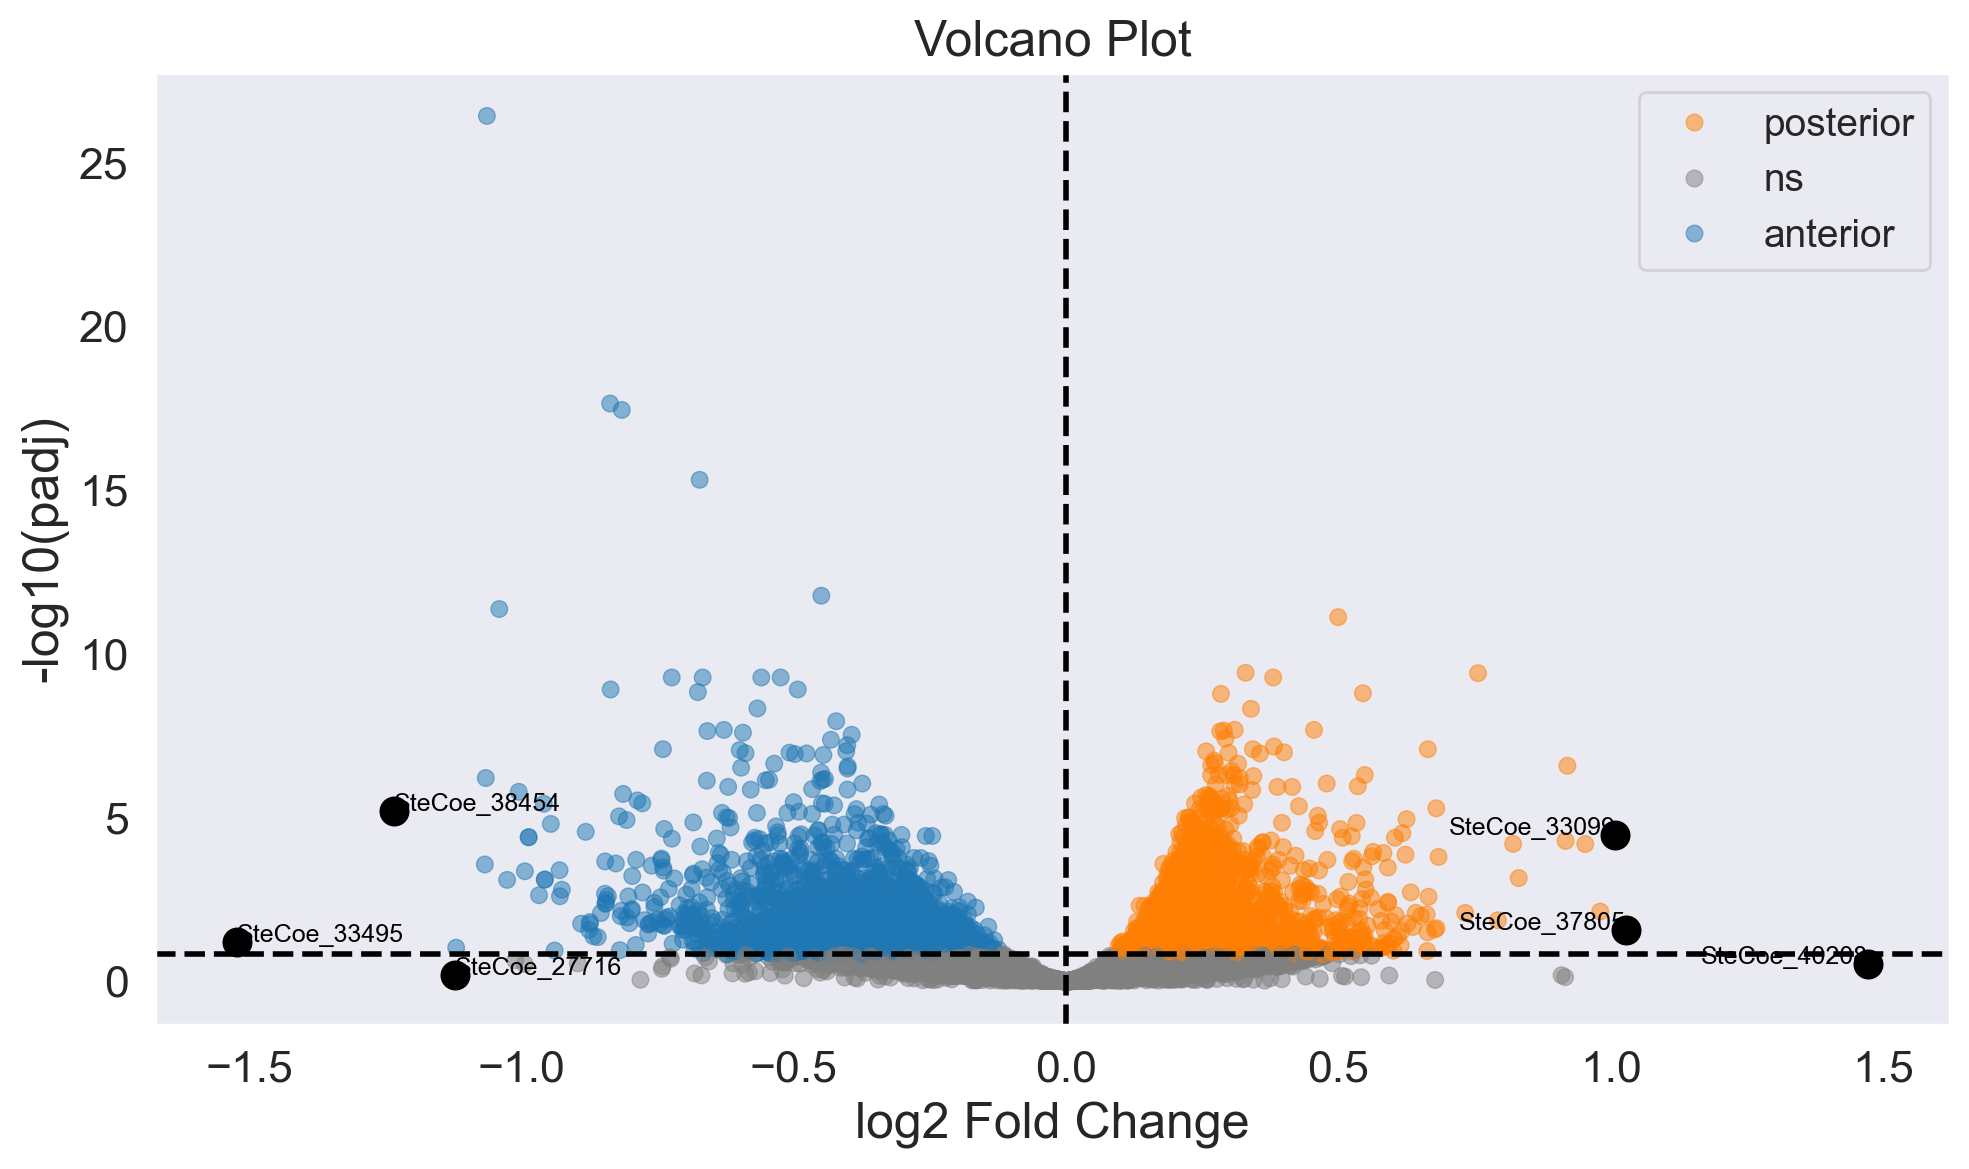

In [41]:
# in case you want to highlight specific genes in a volcano

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define significance threshold
significance_threshold = 0.15

# Create a new column to color points based on significance and log2FoldChange
res.loc[:, 'color'] = np.where(
    (res['padj'] < significance_threshold) & (res['log2FoldChange'] > 0), 'posterior',
    np.where((res['padj'] < significance_threshold) & (res['log2FoldChange'] < 0), 'anterior', 'ns')
)

# Calculate -log10(padj) for the y-axis
res.loc[:, '-log10(padj)'] = -np.log10(res['padj'])

# Filter out rows with non-finite values
res = res[np.isfinite(res['log2FoldChange']) & np.isfinite(res['-log10(padj)'])]

# top 3 and bottom 3 genes based on log2FoldChange
top_genes = res.nlargest(3, 'log2FoldChange')
bottom_genes = res.nsmallest(3, 'log2FoldChange')

# Plotting
plt.figure(figsize=(10, 6))

# Plot all points with their respective colors
sns.scatterplot(
    data=res, 
    x='log2FoldChange', 
    y='-log10(padj)', 
    hue='color', 
    palette={'posterior': '#ff7f03', 'anterior': '#1f77b4', 'ns': 'gray'}, 
    alpha=0.5, 
    edgecolor=None
)

# Plot only the labeled points in black
sns.scatterplot(
    data=pd.concat([top_genes, bottom_genes]),  # Use pd.concat to combine data
    x='log2FoldChange', 
    y='-log10(padj)', 
    color='black', 
    edgecolor=None, 
    s=100  # Increase the size of labeled points for visibility
)

# Add vertical and horizontal lines for thresholds
plt.axhline(y=-np.log10(significance_threshold), color='black', linestyle='--')
plt.axvline(x=0, color='black', linestyle='--')
plt.xlabel('log2 Fold Change')
plt.ylabel('-log10(padj)')
plt.title('Volcano Plot')

# Annotate top 3 and bottom 3 genes
for _, gene in top_genes.iterrows():
    if np.isfinite(gene['log2FoldChange']) and np.isfinite(gene['-log10(padj)']):
        plt.text(gene['log2FoldChange'], gene['-log10(padj)'], gene.name, fontsize=9, ha='right', color='black')
for _, gene in bottom_genes.iterrows():
    if np.isfinite(gene['log2FoldChange']) and np.isfinite(gene['-log10(padj)']):
        plt.text(gene['log2FoldChange'], gene['-log10(padj)'], gene.name, fontsize=9, ha='left', color='black')

plt.tight_layout()
plt.show()
